# Anomaly Detection: 
Identify anomalies in the prices recorded by auditors at various retail stores and locations by using a linear regression model

1. [Problem](#sec_prob)
2. [Import and Merge Data](#sec_import)    
3. [Exploratory Data Analysis (EDA)](#sec_eda)  
4. [Building a model](#sec_model)
5. [Conclusion](#sec_conc)

<a id='sec_prob'></a>
## (1) Problem
- A company collects data from different retailers by sending auditors into physical stores to record pricing and assortment information. This data is then aggregated and validated using several different models and outlier identification techniques. One of these methods is a quick pricing model for price checking that assumes a store price is equal to a base price for the product/UPC multiplied by a store-specific scaling factor and a region-specific scaling factor. 

    This can be represented as 
   
    <center>$ P_{i,j,k} = P_i × A_j × B_k $</center>
    
    for observed price P for product i in store j and region k, where
    - $P_i$ = base price for product/upc i
    - $A_j$ = the store multiplier (range from 0 to infinity) for store j
    - $B_k$ = the region multiplier (range from 0 to infinity) for region k
 
- ***Do you notice anything that seems off with the data we’ve collected? Call out anything you find noteworthy.***

### My approach to the problem
- Using the suggested model 
<center>$ P_{i,j,k} = P_i × A_j × B_k $</center>


- Take $ln()$ of the equation, we get

<center>$ ln(P_{i,j,k}) = ln(P_i) + ln(A_j) + ln(B_k) $</center>

- We can also write


<center> $ ln(Price) = ln(P_1)X_{product1} + ln(P_2)X_{product2} + ... + ln(A_1)X_{store1} + ln(A_2)X_{store2} + ... + ln(B_1)X_{region1} + ln(B_2)X_{region2} + ...$ </center>

- where $X_{product_i}, X_{store_j}, X_{region_k} $ can be 0 or 1.


- Then, we can fit a linear regression model where each product, store, and region becomes a categorical variable with a value of 0 or 1.

- The constants of the regression will be $ln(P_i)$, $ln(A_j)$ and $ln(B_k)$.

- <font color=blue>**Note that, here, I do something different from what suggested in the instruction. I fit the value of $ln(P_i)$, although it is suggested to simply use the median.**  

<a id='sec_import'></a>
## (2) Import Data and Merge

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
auditors_tab = pd.read_csv('auditors.csv')
prices_tab = pd.read_csv('prices.csv')

with open("stores.json", "r") as read_store_file:
    data = json.load(read_store_file)
stores_tab = pd.DataFrame(data)

In [3]:
print ('The Prices table has {} rows and {} columns.'.format(prices_tab.shape[0],prices_tab.shape[1]))
print ('The Stores table has {} rows and {} columns.'.format(stores_tab.shape[0],stores_tab.shape[1]))
print ('The Auditors table has {} rows and {} columns.'.format(auditors_tab.shape[0],auditors_tab.shape[1]))

The Prices table has 12315 rows and 5 columns.
The Stores table has 28 rows and 3 columns.
The Auditors table has 8 rows and 4 columns.


### Merge tables
- I will merge the Prices, Stores, and Auditors tables.

In [4]:
prices_stores_df = pd.merge(prices_tab, stores_tab, on='Store ID', how='left')
tmp = prices_stores_df[prices_stores_df['Banner'].isnull()]['Store ID'].value_counts()
print ('The Prices table has {} store IDs which are not available in the Stores table.'.format(len(tmp)))
print ('\tThose store IDs are: {}'.format(list(tmp.index)))

prices_stores_df = pd.merge(prices_tab, stores_tab, on='Store ID', how='right')
tmp = prices_stores_df[prices_stores_df['Price'].isnull()]['Store ID'].value_counts()
print ('The Stores table has {} store IDs which do not appear in the Prices table.'.format(len(tmp)))
print ('\tThose store IDs are: {}'.format(list(tmp.index)))

The Prices table has 2 store IDs which are not available in the Stores table.
	Those store IDs are: [38472, 60957]
The Stores table has 10 store IDs which do not appear in the Prices table.
	Those store IDs are: [29342, 99997, 6746, 50692, 40582, 59582, 66356, 77955, 39284, 11123]


- We need both price and store information. Therefore, the data with the above store IDs are not useful.
- Hence, I do 'inner join'.

In [5]:
# Merge prices_tab and stores_tab using inner join
prices_stores_df = pd.merge(prices_tab, stores_tab, on='Store ID', how='inner')
print ('The merged prices_stores table has {} rows and {} columns'.format(
                        prices_stores_df.shape[0],prices_stores_df.shape[1]))

The merged prices_stores table has 11511 rows and 7 columns


In [6]:
# auditors_tab has column named Region, the same name is used in stores_tab
# so, let's rename it
auditors_tab.rename(columns={'Region':'Region_aud'},inplace=True)

# Merge prices_stores_df and auditors_tab using left join
prices_stores_aud_df = pd.merge(prices_stores_df, auditors_tab, on='Auditor ID', how='left')
tmp = prices_stores_aud_df[prices_stores_aud_df['First'].isnull()]['Auditor ID'].value_counts()
print ('The prices_stores table has {} Auditor IDs which are not available in the Auditors table.'.format(len(tmp)))

The prices_stores table has 0 Auditor IDs which are not available in the Auditors table.


- This is good. All auditors in the prices_stores table have the information available is the Auditors table.
- I will just use the 'left join'.

In [7]:
# checking if Region and Region_aud are consistent
cond_reg = prices_stores_aud_df['Region'] != prices_stores_aud_df['Region_aud']
prices_stores_aud_df[cond_reg].head(3)

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud
813,98,10/25/17,16.89,39482,286906735,Safeway,Northern California,Jack,Smith,New York
814,98,10/20/17,8.89,39482,672429356,Safeway,Northern California,Jack,Smith,New York
815,98,10/22/17,57.69,39482,506754007,Safeway,Northern California,Jack,Smith,New York


In [8]:
first = prices_stores_aud_df[cond_reg]['First'].value_counts()
last = prices_stores_aud_df[cond_reg]['Last'].value_counts()
reg_aud = prices_stores_aud_df[cond_reg]['Region_aud'].value_counts()
reg = prices_stores_aud_df[cond_reg]['Region'].value_counts()
ban = prices_stores_aud_df[cond_reg]['Banner'].value_counts()
print ('Checking auditors\' region inconsistency:')
print ('  Auditor\'s info',list(first.index), list(last.index), list(reg_aud.index))
print ('  Store\'s info  ',list(reg.index), list(ban.index))

Checking auditors' region inconsistency:
  Auditor's info ['Jack'] ['Smith'] ['New York']
  Store's info   ['Northern California'] ['Safeway']


- There is one inconsistency:
    - <font color=blue> Jack Smith from New York recorded data of the store Safeway in Northern California. </font>

### Sanity checks, null values, and duplicated

In [9]:
prices_stores_aud_df.head(3)

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud
0,234,10/18/17,24.95,66999,268588472,Walmart,Northern California,Sue,Smith,Northern California
1,234,10/27/17,49.71,66999,475245085,Walmart,Northern California,Sue,Smith,Northern California
2,234,10/20/17,25.75,66999,126967843,Walmart,Northern California,Sue,Smith,Northern California


In [10]:
prices_stores_aud_df.tail(3)

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud
11508,304,10/24/17,4.09,98736,47174618,Whole Foods,Texas,Jerry,Johnson,Texas
11509,304,10/18/17,35.59,98736,182310151,Whole Foods,Texas,Jerry,Johnson,Texas
11510,304,10/21/17,37.39,98736,244899396,Whole Foods,Texas,Jerry,Johnson,Texas


In [11]:
# Check null values
prices_stores_aud_df.isnull().sum()

Auditor ID    0
Date          0
Price         0
Store ID      0
UPC           0
Banner        0
Region        0
First         0
Last          0
Region_aud    0
dtype: int64

In [12]:
#check duplicated
print ('Checking duplicated data...')
print ('   There is {} duplicated data.'.format(prices_stores_aud_df.duplicated().sum()))

Checking duplicated data...
   There is 0 duplicated data.


- There is no null value.
- There is no duplicated data.

In [13]:
print ('After merging the Price, Store, and Auditors tables, there are {} rows and {} columns.'.format(
                        prices_stores_aud_df.shape[0],prices_stores_aud_df.shape[1]))

After merging the Price, Store, and Auditors tables, there are 11511 rows and 10 columns.


<a id='sec_eda'></a>
## (3) EDA

In [14]:
print ('There are {} unique products.'.format( len(prices_stores_aud_df['UPC'].unique()) ))

There are 1000 unique products.


In [15]:
prices_stores_aud_df['Region'].value_counts()

Texas                  3765
Kansas                 3087
New York               3025
Northern California    1634
Name: Region, dtype: int64

In [16]:
prices_stores_aud_df['Banner'].value_counts()

Whole Foods    2802
Walmart        2435
Wegmans        2249
Trader Joes    2062
Safeway        1963
Name: Banner, dtype: int64

There are 
- 1000 unique products
- 4 unique regions
- 5 unique banners

### Look at the Price
- Since our target variable is the price, it is always good to look at its distribution.

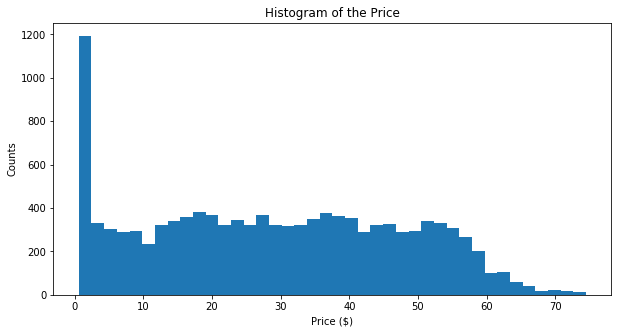

In [17]:
_ = plt.figure(figsize=(10, 5))
_ = plt.hist( prices_stores_aud_df['Price'], bins= 40)
_ = plt.xlabel("Price ($)")
_ = plt.ylabel("Counts")
_ = plt.title("Histogram of the Price")

- <font color=blue>There is a suspiciously high number of counts with the price of ~ $0-3. I will look closely into this.</font>

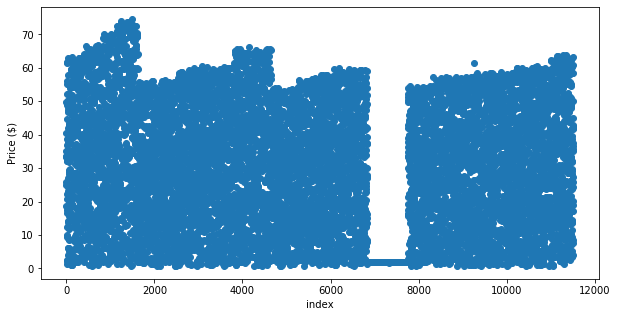

In [18]:
start_index = 0
end_index = prices_stores_aud_df.index[-1]
x_var = prices_stores_aud_df.index[start_index:end_index+1]
y_var = prices_stores_aud_df['Price'].loc[start_index:end_index+1]
_ = plt.figure(figsize=(10, 5))
_ = plt.scatter(x_var,y_var, )
_ = plt.xlabel("index")
_ = plt.ylabel("Price ($)")

### What are those low prices?
- Those are data at the index of ~6500-8000.
- After taking a close look, by changing start_index, end_index, I found the following.
    - There are unusual prices of $1.99 recorded, starting from index 6833-7745.
    
        - These are recorded at the store ID: 39287 ('Whole Foods' & 'Kansas')
    
        - There are 912 records with a price of $1.99.
    
        - There is also a record of $1.49.

In [19]:
prices_stores_aud_df.loc[6833:7745].head(3)

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud
6833,713,10/24/17,1.99,39287,557031026,Whole Foods,Kansas,Dave,Johnson,Kansas
6834,713,10/29/17,1.99,39287,866698043,Whole Foods,Kansas,Dave,Johnson,Kansas
6835,713,10/27/17,1.99,39287,514730047,Whole Foods,Kansas,Dave,Johnson,Kansas


In [20]:
prices_stores_aud_df.loc[6833:7745]['Store ID'].value_counts()

39287    913
Name: Store ID, dtype: int64

In [21]:
prices_stores_aud_df[prices_stores_aud_df['Store ID'] == 39287]['Price'].value_counts()

1.99    912
1.49      1
Name: Price, dtype: int64

### Removing the suspicious values
   - These suspicious values seem to be incorrectly recorded at 'Store ID' = 39287

In [22]:
# remove the data with Store ID = 39287
cond_199 = prices_stores_aud_df['Store ID'] != 39287
prices_stores_df_clean = prices_stores_aud_df[cond_199] # let's keep the original index here

In [23]:
print ('After data cleaning, the data has {} rows and {} columns'.format(
                                        prices_stores_df_clean.shape[0], prices_stores_df_clean.shape[1]))

After data cleaning, the data has 10598 rows and 10 columns


In [24]:
# checking null values and value types for the last time  
prices_stores_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10598 entries, 0 to 11510
Data columns (total 10 columns):
Auditor ID    10598 non-null int64
Date          10598 non-null object
Price         10598 non-null float64
Store ID      10598 non-null int64
UPC           10598 non-null int64
Banner        10598 non-null object
Region        10598 non-null object
First         10598 non-null object
Last          10598 non-null object
Region_aud    10598 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 910.8+ KB


#### Histogram after data cleaning

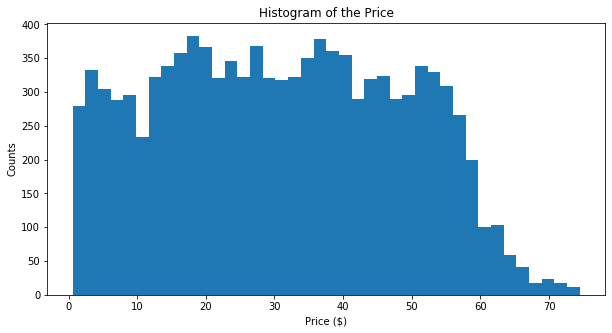

In [25]:
_ = plt.figure(figsize=(10, 5))
_ = plt.hist( prices_stores_df_clean['Price'], bins= 40)
_ = plt.xlabel("Price ($)")
_ = plt.ylabel("Counts")
_ = plt.title("Histogram of the Price")

<a id='sec_model'></a>
## (4) Build a Model


In [26]:
prices_stores_df_clean.head(3)

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud
0,234,10/18/17,24.95,66999,268588472,Walmart,Northern California,Sue,Smith,Northern California
1,234,10/27/17,49.71,66999,475245085,Walmart,Northern California,Sue,Smith,Northern California
2,234,10/20/17,25.75,66999,126967843,Walmart,Northern California,Sue,Smith,Northern California


### Preparing target variable and features

In [27]:
# calulcate the ln() of the Price
prices_stores_df_clean['ln_Price'] = prices_stores_df_clean['Price'].apply(lambda x: math.log(x))

In [28]:
x_vars = prices_stores_df_clean[['UPC','Banner','Region']]
# make product UPC values be string so that we can do one-hot encoded
x_vars['UPC'] = x_vars['UPC'].astype(str)
# one-hot encoded all categories 
df_x_dum = pd.get_dummies(x_vars)

y_lnPrice = prices_stores_df_clean['ln_Price'] # this is a series

### Fitting a linear regression model
- My model has intercept value = 0.
- Since we want to detect anomaly in this specific data set, ***I use all data in the training and I do not expect the trained model to apply to other data sets.***

In [29]:
import statsmodels.api as sm
est = sm.OLS(y_lnPrice, df_x_dum)
linear_reg = est.fit()
print(linear_reg.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.662e+04
Date:                Thu, 09 Jan 2020   Prob (F-statistic):               0.00
Time:                        19:58:37   Log-Likelihood:                 33517.
No. Observations:               10598   AIC:                        -6.502e+04
Df Residuals:                    9591   BIC:                        -5.770e+04
Df Model:                        1006                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
UPC_101201265       

- All coefficients has p-value < 0.05 (significant) except  the 'UPC_106918220'

In [30]:
y_ln_pred = linear_reg.predict()

In [31]:
print ("The R^2 value of the fit is {}.".format(round(linear_reg.rsquared,5)))

The R^2 value of the fit is 0.99986.


- The model has very good R^2 value, 99.99% of the variance in the price is explained by the included features.

### Which region is the most expensive?

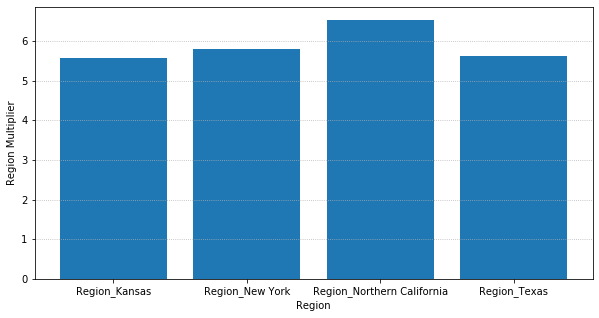

In [32]:
x = list((np.exp(linear_reg.params[-4:])).index)
y = list(np.exp(linear_reg.params[-4:]))
_ = plt.figure(figsize=(10,5))
_ = plt.bar(x, y)
_ = plt.grid(linestyle=':',axis='y')
_ = plt.xlabel("Region")
_ = plt.ylabel("Region Multiplier")

In [33]:
print ('The region multipliers are:')
print ( np.exp(linear_reg.params[-4:]).to_string() )

The region multipliers are:
Region_Kansas                 5.567694
Region_New York               5.791183
Region_Northern California    6.524399
Region_Texas                  5.623198


### Which store is the most expensive?

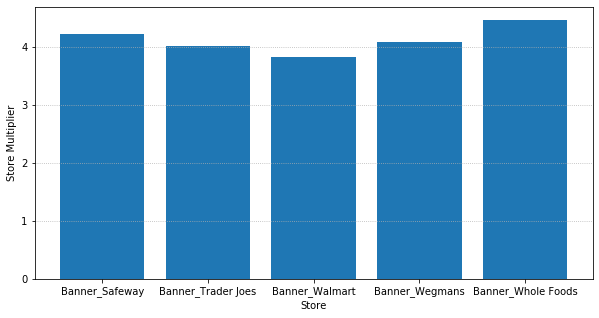

In [34]:
x = list((np.exp(linear_reg.params[-9:-4])).index)
y = list(np.exp(linear_reg.params[-9:-4]))
_ = plt.figure(figsize=(10,5))
_ = plt.bar(x, y)
_ = plt.grid(linestyle=':',axis='y')
_ = plt.xlabel("Store")
_ = plt.ylabel("Store Multiplier")

In [35]:
print ('The store multipliers are:')
print ( np.exp(linear_reg.params[-9:-4]).to_string() )

The store multipliers are:
Banner_Safeway        4.218067
Banner_Trader Joes    4.012087
Banner_Walmart        3.822253
Banner_Wegmans        4.094975
Banner_Whole Foods    4.465932


### Plotting ln(Price) vs ln(Predicted Price)

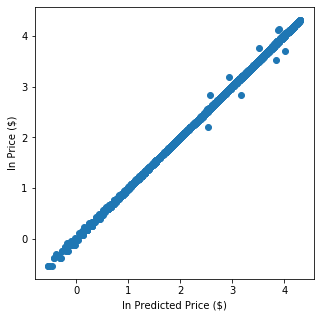

In [36]:
_ = plt.figure(figsize=(5, 5))
_ = plt.scatter(y_ln_pred, y_lnPrice)
_ = plt.xlabel("ln Predicted Price ($)")
_ = plt.ylabel("ln Price ($)")

#### Plot residuals of ln(Price) vs ln (Predicted Price)

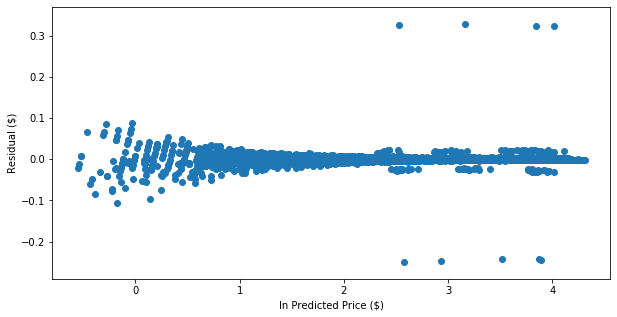

In [37]:
res = (y_ln_pred-y_lnPrice)
_ = plt.figure(figsize=(10,5))
_ = plt.scatter(y_ln_pred, res)
_ = plt.xlabel("ln Predicted Price ($)")
_ = plt.ylabel("Residual ($)")

### Plotting Price vs Predicted Price

In [38]:
# calculate predicted price from y_ln_pred
df_price_comp = prices_stores_df_clean.copy()
df_price_comp['price_pred'] = y_ln_pred
df_price_comp['price_pred'] = df_price_comp['price_pred'].apply(lambda x: math.exp(x))

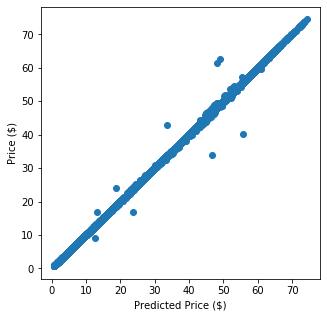

In [39]:
# plot predicted price vs price
_ = plt.figure(figsize=(5, 5))
_ = plt.scatter(df_price_comp['price_pred'], df_price_comp['Price'])
_ = plt.xlabel("Predicted Price ($)")
_ = plt.ylabel("Price ($)")

#### Plotting Residual, Percentage Residual, and Standardized Residual

In [40]:
# calculate residual and percentage residual
price_recd = df_price_comp['Price']
price_pred = df_price_comp['price_pred']
res_price = (price_pred-price_recd)
df_price_comp['res_price'] = res_price
df_price_comp['pct_res_price'] = res_price*100/price_recd

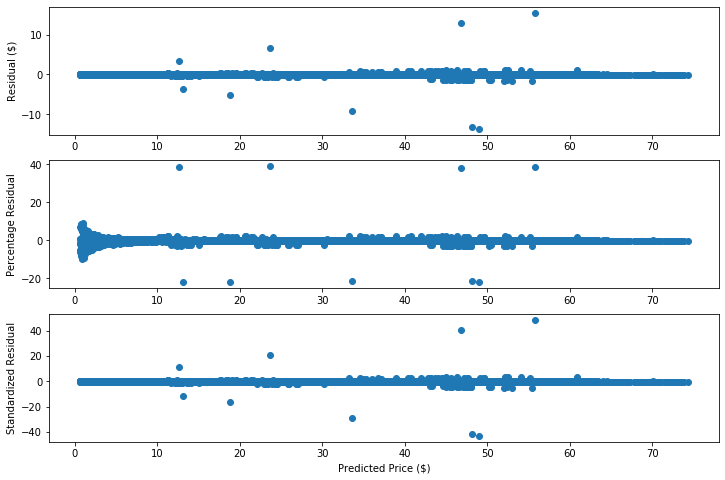

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(311)
_ = plt.scatter(df_price_comp['price_pred'], df_price_comp['res_price'])
_ = plt.ylabel("Residual ($)")

ax2 = fig.add_subplot(312)
_ = plt.scatter(df_price_comp['price_pred'], df_price_comp['pct_res_price'])
_ = plt.ylabel("Percentage Residual")

ax3 = fig.add_subplot(313)
rse = np.std(res_price)
stdized_res = res_price/rse
df_price_comp['stdz_res'] = stdized_res
_ = plt.scatter(df_price_comp['price_pred'], df_price_comp['stdz_res'])
_ = plt.xlabel("Predicted Price ($)")
_ = plt.ylabel("Standardized Residual")

###### What are the records that seem off?
   - Look at the records with large residual (larger than 6 standard deviations).

In [42]:
cond = (df_price_comp['stdz_res']>6) | (df_price_comp['stdz_res']<-6)
df_price_comp[cond]

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region,First,Last,Region_aud,ln_Price,price_pred,res_price,pct_res_price,stdz_res
813,98,10/25/17,16.89,39482,286906735,Safeway,Northern California,Jack,Smith,New York,2.826722,13.159685,-3.730315,-22.085940,-11.791267
860,98,10/27/17,40.29,39482,269161785,Safeway,Northern California,Jack,Smith,New York,3.696103,55.743775,15.453775,38.356354,48.848309
2536,203,10/17/17,33.89,9487,565229692,Trader Joes,New York,Jill,Smith,New York,3.523120,46.796051,12.906051,38.082180,40.795130
4276,98,10/24/17,62.69,50948,790347148,Whole Foods,New York,Jack,Smith,New York,4.138202,49.029722,-13.660278,-21.790203,-43.179191
5672,713,10/24/17,24.09,3948,927693101,Wegmans,Kansas,Dave,Johnson,Kansas,3.181797,18.815769,-5.274231,-21.893862,-16.671479
5790,713,10/25/17,16.99,3948,376153383,Wegmans,Kansas,Dave,Johnson,Kansas,2.832625,23.608066,6.618066,38.952712,20.919246
7764,63,10/23/17,42.79,50495,301161010,Walmart,Texas,Randy,Johnson,Texas,3.756304,33.609700,-9.180300,-21.454313,-29.018291
9253,304,10/27/17,61.39,98638,971923169,Wegmans,Texas,Jerry,Johnson,Texas,4.117247,48.163875,-13.226125,-21.544428,-41.806861
10056,304,10/21/17,9.09,98638,930355523,Wegmans,Texas,Jerry,Johnson,Texas,2.207175,12.585137,3.495137,38.450348,11.047884


- save the anomalies into a file

In [43]:
df_price_comp[cond].to_csv('anomalies.csv')

<a id='sec_conc'></a>
## (5) Conclusion

Do you notice anything that seems off with the data we’ve collected? Call out anything you find noteworthy.
- The following are what I notice:
    - There is one inconsistency in the auditor's region vs store's region:
        - Jack Smith from New York recorded data of the store Safeway in Northern California.
    - There are unusual prices of 1.99 USD (912 values) and 1.49 USD (1 value) recorded at the store ID: 39287 (which corresponds to 'Whole Foods' in 'Kansas') 
        - These suspicious values seem to be incorrectly recorded.
        - I remove these values before fitting the model.
    - After fitting a linear model, 9 data points are very off (listed above and also saved in the file ***'anomalies.csv'***). 
        - 5 of them have percentage residual of about 22%
        - 4 of them have percentage residual of about 38%
        - These outliers do not look very random. There is probably a systematic error when these values were recorded.